Random tree forest

In [20]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

In [21]:
path = '../data/paris_dataset_final_ready.csv.gz'
data_path = Path(path)
if not data_path.exists():
    raise FileNotFoundError(f"Dataset introuvable : {data_path}")
df = pd.read_csv(data_path, compression='gzip')
print(df.columns.tolist())

['accommodates', 'bedrooms', 'beds', 'minimum_nights_avg_ntm', 'number_of_reviews', 'price_clean', 'dist_to_center', 'bathrooms_qty', 'has_ac', 'has_elevator', 'has_dishwasher', 'has_parking', 'has_balcony', 'has_washing_machine', 'standing_thermal', 'score_chef_kitchen', 'score_coffee', 'score_wellness', 'score_work', 'score_view', 'score_secure', 'neigh_popularity', 'pg_entire_unit', 'pg_hotel', 'pg_private_room', 'rt_Entire home/apt', 'rt_Private room', 'rt_Shared room', 'city_label', 'target_class']


Séparation X (features) et y (target)

In [22]:
y = df['target_class']
X = df.drop(columns=['target_class', 'price_clean', 'city_label'])
# On drop évidemment le prix discret et le label de ville inutile ici

print(f"\nFeatures (X) : {X.shape[1]} colonnes")
print(f"Target (y) : {len(y)} valeurs")
print(f"\nDistribution des classes :")
print(y.value_counts().sort_index())


Features (X) : 27 colonnes
Target (y) : 73111 valeurs

Distribution des classes :
target_class
0    19114
1    17449
2    18299
3    18249
Name: count, dtype: int64


Train-test split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=123
)   # on stratify pour garder la même répartition des classes dans train et test

Grid search pour trouver les meilleurs hyperparamètres avec validation croisée

In [24]:
# hyperparamètres à explorer
param_grid = {
    # sqrt(p) est le choix classique, log2 plus conservateur
    'max_features': ['sqrt', 'log2'], 

    # plus on en met, plus la variance baisse — mais ça finit par plafonner
    'n_estimators': [100, 300], 

    # plus c'est profond, plus le modèle risque de mémoriser
    'max_depth': [10, 15, 20, 30],

    # nombre min d'échantillons dans une feuille, pour lisser la variance
    'min_samples_leaf': [2, 5, 10]
}


In [25]:
def run_custom_grid_search(X, y, scoring_metric='accuracy'):
    print(f"\n Lancement de la Grid Search (Métrique : {scoring_metric})...")
    
    rf = RandomForestClassifier(random_state=123, n_jobs=-1)
    
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,                  # 5-Fold Cross Validation
        scoring=scoring_metric,
        return_train_score=True, # Pour analyser le biais
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X, y)
    
    results = pd.DataFrame(grid_search.cv_results_)
    
    cols_interest = [
        'param_max_depth', 'param_max_features', 'param_min_samples_leaf', 'param_n_estimators',
        'mean_test_score', 'std_test_score',  # Performance Validation (Variance)
        'mean_train_score'                    # Performance Train (Biais inverse)
    ]
    summary = results[cols_interest].copy()
    
    # Renommage pour clarté
    summary.rename(columns={
        'mean_test_score': 'Score_Moyen_CV',
        'std_test_score': 'Ecart_Type_CV (Variance)',
        'mean_train_score': 'Score_Train (Overfit?)'
    }, inplace=True)
    
    # Tri par meilleur score de validation
    summary = summary.sort_values(by='Score_Moyen_CV', ascending=False)
    
    return grid_search.best_estimator_, summary

grid search sur l'accuracy et le F1-macro

In [8]:
# grid search sur l'accuracy
best_model_acc, res_acc = run_custom_grid_search(X_train, y_train, scoring_metric='accuracy')

print("\n top 5 configurations (accuracy) :")
# on regarde le top 5 pour choisir manuellement le meilleur compromis
print(res_acc.head(5).to_string(index=False))



 Lancement de la Grid Search (Métrique : accuracy)...
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/Delphine/Library/CloudStorage/OneDrive-Personnel/Visual_Studio_Code/Projet_ML_legend/ML_Airbnb_domain_generalisation/data_science_env/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/Delphine/Library/CloudStorage/OneDrive-Personnel/Visual_Studio_Code/Projet_ML_legend/ML_Airbnb_domain_generalisation/data_science_env/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/Delphine/Library/CloudStorage/OneDrive-Personnel/Visual_Studio_Code/Projet_ML_legend/ML_Airbnb_domain_generalisation/data_science_env/lib/p


 top 5 configurations (accuracy) :
 param_max_depth param_max_features  param_min_samples_leaf  param_n_estimators  Score_Moyen_CV  Ecart_Type_CV (Variance)  Score_Train (Overfit?)
              20               log2                       2                 300        0.560081                  0.006387                0.846028
              20               sqrt                       2                 300        0.559910                  0.005100                0.861848
              20               sqrt                       5                 300        0.559841                  0.005041                0.732539
              20               log2                       5                 300        0.559140                  0.006273                0.716938
              30               sqrt                       5                 300        0.559123                  0.004630                0.753522


5 blocs pour la CV — avec 73k lignes ça donne environ 14k échantillons par fold, suffisant pour des estimations solides sans que ça tourne pendant des heures.

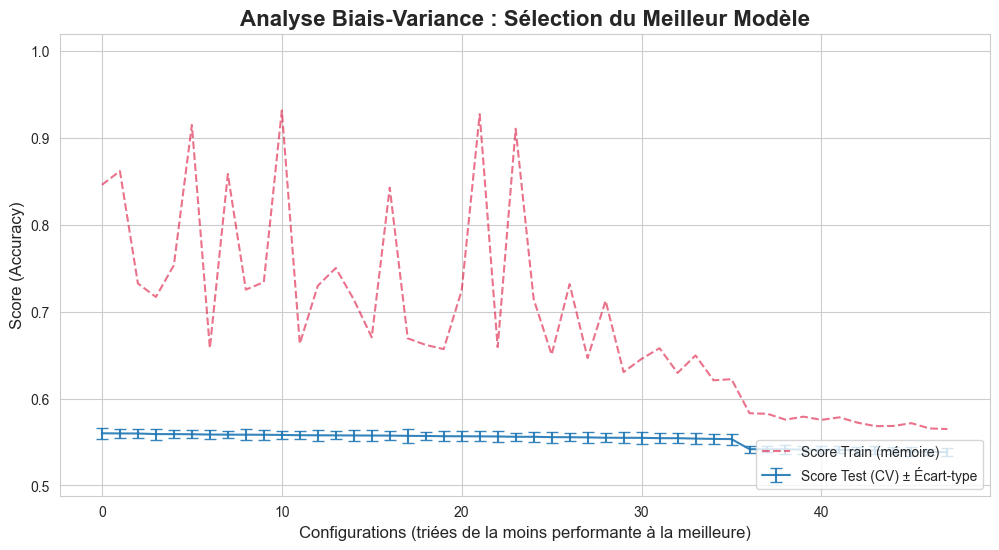

In [9]:
# A relancer si jamais on relance la grid search pour avoir les résultats à jour

plt.figure(figsize=(12, 6))

x_axis = range(len(res_acc))

# score moyen en validation avec barres d'erreur (écart-type)
plt.errorbar(
    x=x_axis,
    y=res_acc['Score_Moyen_CV'],
    yerr=res_acc['Ecart_Type_CV (Variance)'],
    elinewidth=1.5,
    capsize=4,
    alpha=0.9,
    label='Score Test (CV) ± Écart-type'
)

# score sur le train pour repérer l'overfit
plt.plot(
    x_axis,
    res_acc['Score_Train (Overfit?)'],
    color='crimson',
    linestyle='--',
    alpha=0.6,
    label='Score Train (mémoire)'
)

plt.title('Analyse Biais-Variance : Sélection du Meilleur Modèle', fontsize=16, fontweight='bold')
plt.xlabel('Configurations (triées de la moins performante à la meilleure)', fontsize=12)
plt.ylabel('Score (Accuracy)', fontsize=12)
plt.legend(loc='lower right', frameon=True)

min_y = res_acc['Score_Moyen_CV'].min() - 0.05
plt.ylim(min_y, 1.02)

plt.show()


### compromis biais-variance

à gauche du graphique, les configs avec les arbres très profonds mémorisent le train (score rouge proche de 90%) mais stagnent en validation autour de 0.56 — le gap est assez parlant.

vers la droite, le score d'entraînement redescend (~73%) mais le test reste stable. c'est la zone qui nous intéresse : moins de mémoire, plus de généralisation.

on teste aussi le F1-macro pour voir si ça change quelque chose — en théorie non, les classes sont équilibrées par construction. à ne pas relancer !

In [10]:
# TEST SUR LE F1-MACRO
best_model_f1, res_f1 = run_custom_grid_search(X_train, y_train, scoring_metric='f1_macro')

print("\n TOP 5 CONFIGURATIONS (F1-MACRO) :")
print(res_f1.head(5).to_string(index=False))


 Lancement de la Grid Search (Métrique : f1_macro)...
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/Delphine/Library/CloudStorage/OneDrive-Personnel/Visual_Studio_Code/Projet_ML_legend/ML_Airbnb_domain_generalisation/data_science_env/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/Delphine/Library/CloudStorage/OneDrive-Personnel/Visual_Studio_Code/Projet_ML_legend/ML_Airbnb_domain_generalisation/data_science_env/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/Delphine/Library/CloudStorage/OneDrive-Personnel/Visual_Studio_Code/Projet_ML_legend/ML_Airbnb_domain_generalisation/data_science_env/lib/p


 TOP 5 CONFIGURATIONS (F1-MACRO) :
 param_max_depth param_max_features  param_min_samples_leaf  param_n_estimators  Score_Moyen_CV  Ecart_Type_CV (Variance)  Score_Train (Overfit?)
              20               sqrt                       2                 300        0.550632                  0.005294                0.861492
              20               log2                       2                 300        0.550313                  0.006540                0.845385
              20               sqrt                       5                 300        0.549906                  0.005348                0.728854
              30               log2                       2                 300        0.549513                  0.004850                0.915007
              30               sqrt                       2                 300        0.549289                  0.004960                0.931642


le meilleur modèle en F1-macro correspond au 2ème en accuracy, mais avec une variance nettement plus faible. c'est lui qu'on retient.

Entrainement du modele optimal

In [11]:
# On hardcode les parametres optimaux pour ne pas avoir a relancer la grid search
opti_max_depth = 20
opti_param_max_features = 'sqrt'
opti_param_min_samples_leaf = 5
opti_param_n_estimators = 300

In [12]:
rf_opti = RandomForestClassifier(
    n_estimators=opti_param_n_estimators,
    max_depth=opti_max_depth,
    min_samples_leaf=opti_param_min_samples_leaf,
    max_features=opti_param_max_features,
    random_state=123,
    n_jobs=-2       # on garde un peu de cpu
)

In [13]:
rf_opti.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

Exemple simplifié d'une prédiction sur un appartement de test

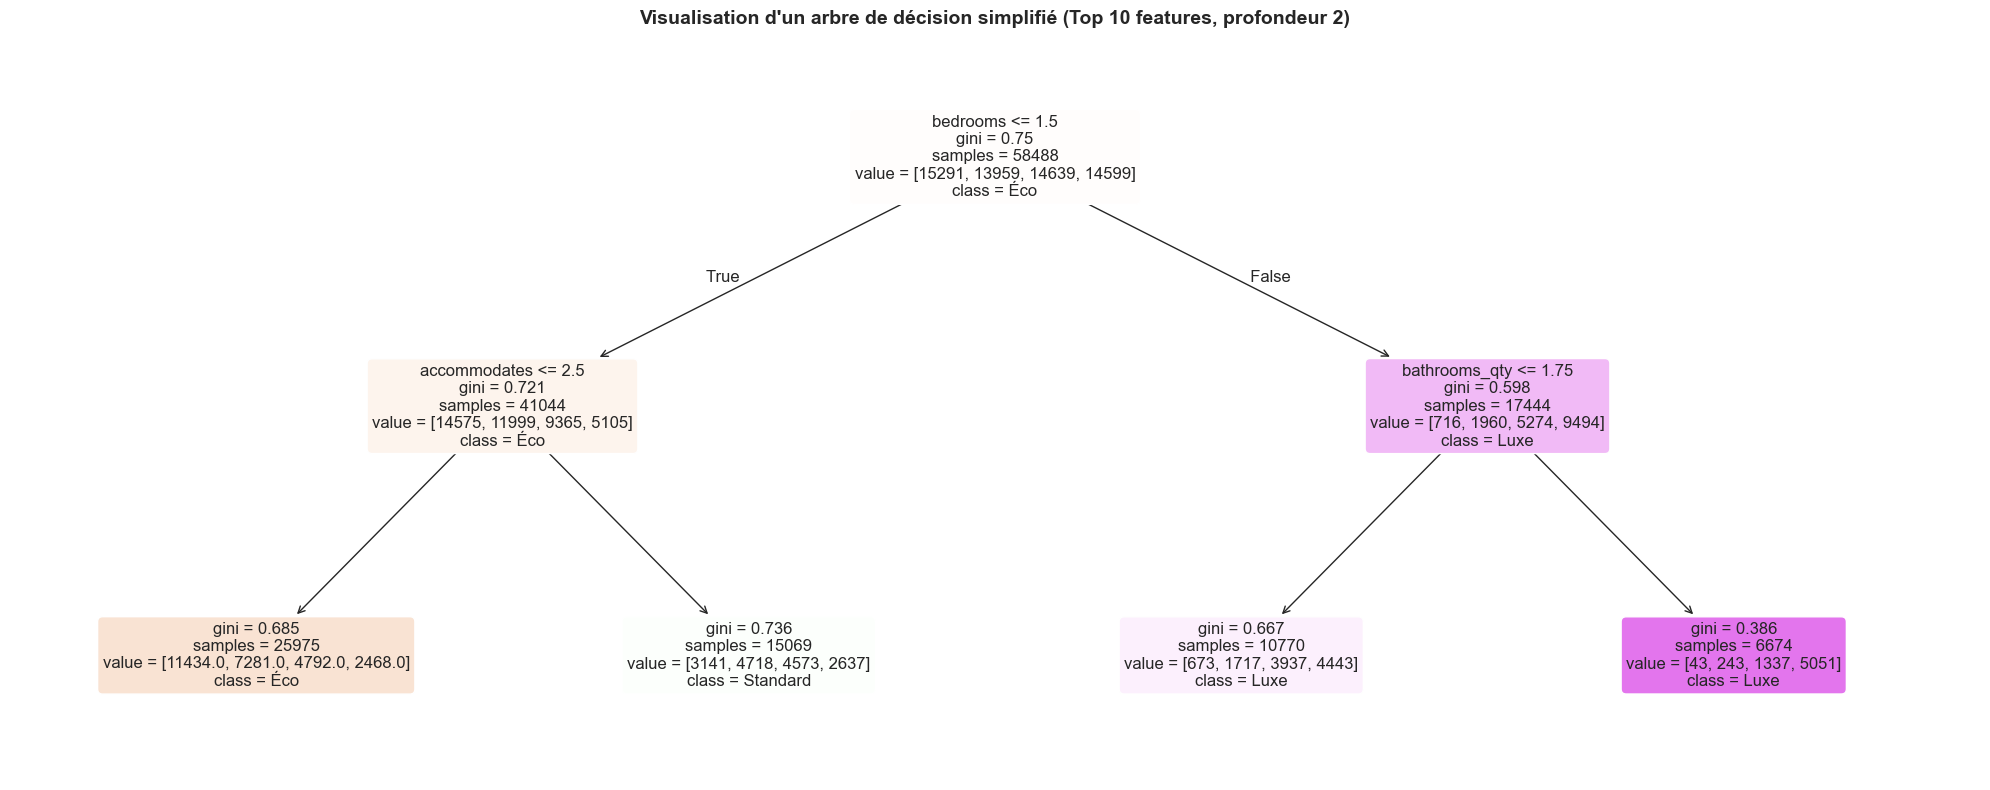

In [14]:
from sklearn.tree import plot_tree

# On calcule les features les plus importantes pour filtrer la visualisation
top_features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_opti.feature_importances_
}).sort_values(by='Importance', ascending=False)['Feature'].head(10).tolist()

# On entraîne un arbre simple avec seulement les top features, uniquement pour la visualisation
dt_visu = DecisionTreeClassifier(max_depth=2, random_state=123)
dt_visu.fit(X_train[top_features], y_train)

plt.figure(figsize=(20, 8))
plot_tree(
    dt_visu,
    feature_names=top_features,
    class_names=['Éco', 'Standard', 'Premium', 'Luxe'],
    filled=True,
    max_depth=2,
    fontsize=12,
    rounded=True,
    impurity=True
)
plt.title("Visualisation d'un arbre de décision simplifié (Top 10 features, profondeur 2)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


Résultats du modèle optimal sur le test set

In [15]:
y_pred = rf_opti.predict(X_test)
# Score
acc = accuracy_score(y_test, y_pred)
f1_macro = classification_report(y_test, y_pred, output_dict=True)['macro avg']['f1-score']
print(f"\n PRÉCISION FINALE (Accuracy) : {acc:.2%}")
print(f" F1-MACRO : {f1_macro:.2%}")


 PRÉCISION FINALE (Accuracy) : 56.73%
 F1-MACRO : 55.75%


In [16]:
target_names = ['Éco (0)', 'Standard (1)', 'Premium (2)', 'Luxe (3)']
print("\n--- RAPPORT DE CLASSIFICATION ---")
print(classification_report(y_test, y_pred, target_names=target_names))


--- RAPPORT DE CLASSIFICATION ---
              precision    recall  f1-score   support

     Éco (0)       0.61      0.73      0.66      3823
Standard (1)       0.44      0.39      0.42      3490
 Premium (2)       0.50      0.43      0.46      3660
    Luxe (3)       0.67      0.70      0.69      3650

    accuracy                           0.57     14623
   macro avg       0.56      0.56      0.56     14623
weighted avg       0.56      0.57      0.56     14623



Le score OOB est une estimation interne de la performance du modèle : chaque arbre est évalué sur les échantillons qu'il n'a pas vus pendant son entraînement. Si ce score est proche du score de test, c'est bon signe.

In [17]:
print("\n=== validation OOB (out-of-bag) ===")

# mêmes paramètres que rf_opti, juste avec oob_score=True en plus
rf_oob = RandomForestClassifier(
    n_estimators=opti_param_n_estimators,
    max_depth=opti_max_depth,
    min_samples_leaf=opti_param_min_samples_leaf,
    max_features=opti_param_max_features,
    oob_score=True,
    random_state=123
)

rf_oob.fit(X_train, y_train)

oob_acc = rf_oob.oob_score_
test_acc = accuracy_score(y_test, rf_oob.predict(X_test))

print(f" OOB (estimation interne) : {oob_acc:.4f}")
print(f" score test (validation réelle) : {test_acc:.4f}")

if abs(oob_acc - test_acc) < 0.02:
    print("les deux scores sont très proches, le modèle généralise bien.")



=== validation OOB (out-of-bag) ===
 OOB (estimation interne) : 0.5596
 score test (validation réelle) : 0.5673
les deux scores sont très proches, le modèle généralise bien.


Validation OOB

Le score OOB (0.5599) est très proche de l'accuracy sur le test set (0.57). ça confirme que les résultats ne dépendent pas du découpage train/test en particulier — le modèle est stable.

Matrice de Confusion

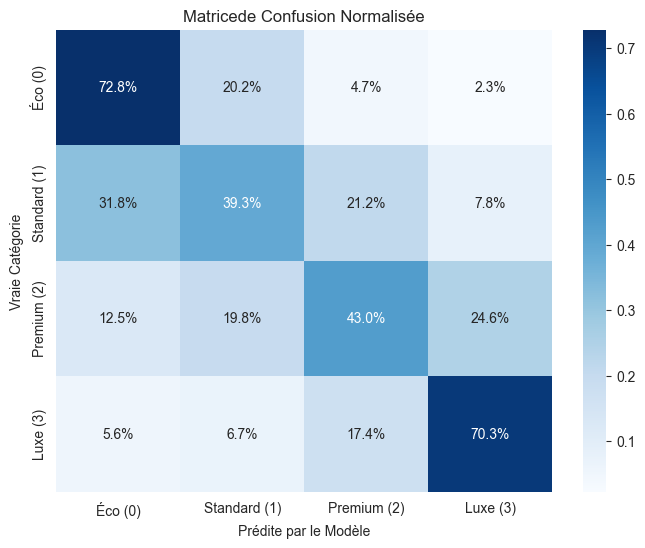

In [18]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)

# On normalise pour avoir des pourcentages 
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cmn, annot=True, fmt='.1%', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Vraie Catégorie')
plt.xlabel('Prédite par le Modèle')
plt.title('Matricede Confusion Normalisée')
plt.show()

### lecture de la matrice de confusion

Le modèle se débrouille bien sur les extrêmes : **Éco** à 72.9% et **Luxe** à 70.1%. ces deux catégories ont des profils assez distincts, le modèle les capte sans trop de mal.

Là où ça coince, c'est entre **Standard** et **Premium** (autour de 40% chacun). la différence entre ces deux classes tient souvent à des critères visuels — décoration, luminosité, charme — que les données tabulaires ne capturent pas vraiment.

Les confusions restent cohérentes : le modèle se trompe quasi-toujours d'une classe au plus. les erreurs graves (Éco confondu avec Luxe ou inversement) représentent moins de 6% des cas.

INTERPRÉTATION (FEATURE IMPORTANCE)

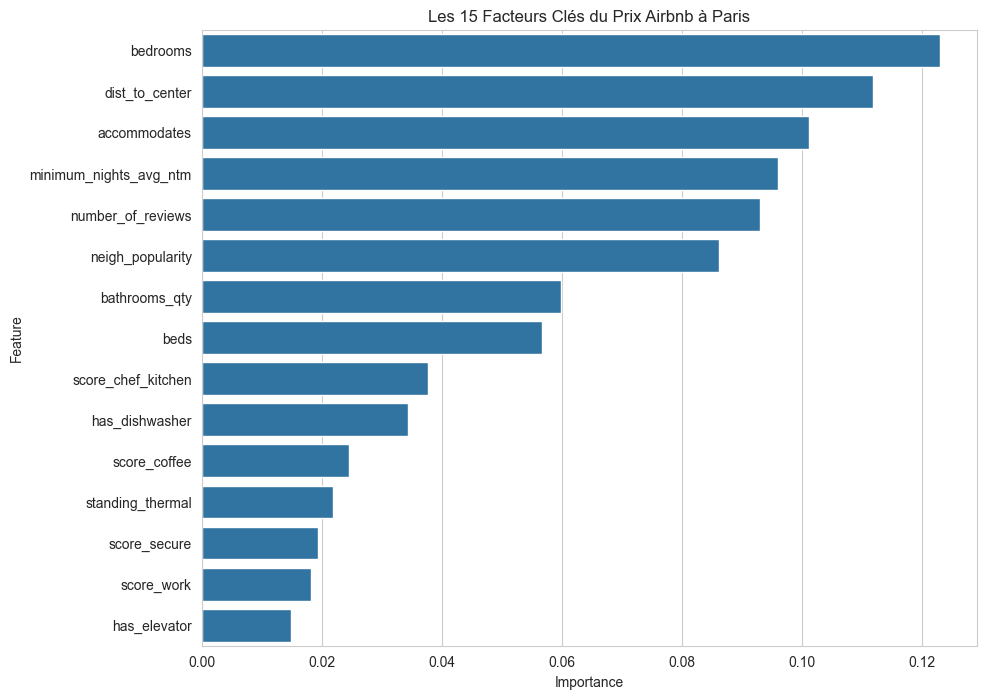

In [19]:
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_opti.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importances.head(15))
plt.title('Les 15 Facteurs Clés du Prix Airbnb à Paris')
plt.show()

La feature importance mesure la contribution cumulée de chaque variable à réduire l'impureté de Gini à travers tous les arbres. plus une variable sépare efficacement les classes, plus son score est élevé.

### Ce qui influence le prix à Paris

Sans surprise, c'est la **taille du logement** qui domine : bedrooms, accommodates et beds sont en tête. la **dist_to_center** arrive juste après — la logique immobilière parisienne est bien capturée.

Ce graphique classe les variables selon leur impact sur la décision de l'algorithme :

1.  **La structure de l'appartement :** La variable **bedrooms** est le prédicteur n°1, suivie de près par **accommodates** (capacité) et **beds**. C'est la taille du logement qui dicte massivement le prix.
2.  **L'Emplacement :** La **dist_to_center** (distance à Notre-Dame) est le 2ème facteur le plus influent, confirmant la logique immobilière parisienne.
3.  **La réputation :** Les variables **minimum_nights** et **number_of_reviews** sont étonnamment hautes. Cela suggère que les loueurs professionnels (qui imposent des séjours longs et accumulent les avis) ont des stratégies tarifaires distinctes des particuliers.
4.  **L'Équipement :** La présence de salles de bain multiples (**bathrooms_qty**) et d'une cuisine équipée (**score_chef_kitchen**) sont les marqueurs de confort les plus discriminants.

### Résumé des performances

57% d'accuracy sur 4 classes équilibrées — sachant que le hasard pur ferait 25%, le modèle apprend clairement quelque chose.

Le F1-macro à 0.56 confirme qu'on ne triche pas en favorisant une classe : les performances sont assez homogènes. les classes extrêmes (Éco et Luxe) sont mieux prédites, les intermédiaires restent difficiles à distinguer sans données visuelles.

Globalement le modèle est utilisable pour filtrer des gammes de prix, même s'il ne faut pas attendre une précision chirurgicale sur Standard vs Premium.